# Transaction Fraud detection

# Набор данных Banksim
Мы выявляем мошеннические транзакции из набора данных Banksim. 
Этот синтетически созданный набор данных состоит из платежей от разных клиентов, произведенных в
разные периоды времени и с разными суммами. 

# Описание колонок
* Step: Означает день со старта симуляции (максимум 180, т.е примерно 6 месяцев).
* Customer: Идентификатор покупателя
* zipCodeOrigin: ZIP код покупателя
* Merchant: Идентификатор продавца
* zipMerchant: ZIP код продавца
* Age: категоризованный возраст
0: <= 18,
1: 19-25,
2: 26-35,
3: 36-45,
4: 46-55,
5: 56-65,
6: > 65
U: Неизвестно (Unknown)
* Gender: Gender for customer
E: Компания (Enterprise),
F: Женский (Female),
M: Мужской (Male,
U: Неизвестно (Unknown)
* Category: Категория покупки
* Amount: Объем транзакции
* Fraud: 1 (fraud, мошенничество), 0 (обычная транзакция)

Задание

1) Проведите первичный анализ данных, сформулируйте эвристики для детекции фрода (аномалий), которые можно использовать в качестве базового решения. Приведите метрики качества для оценки вашего алгоритма.

2) Попробуйте получить решение лучше по метрикам (с помощью модели ML), чем эвристика, помните, что класс 1 (мошенничество) в целом скорее важнее, чем класс 0.

3) Изучите одну из техник балансировки выборки (например, оверсемплинг с помощью метода SMOTE) и попробуйте еще улучшить качество алгоритма.

4) Выберите лучший алгоритм по пунктам 1-2-3 и внесите часть тестовой выборки (с предсказанием) в вашу учебную базу, а затем постройте дэшборд в redash в котором будет отражена информация о количестве фродовых транзакций за неделю, а также будут выведены последние 10 фродовых транзакций, требующих проверки.


https://sato-1.ru/pediatric-otolaryngologists/vysokoe-kolichestvo-froda-chto-takoe-frod-v-mobilnoi-reklame/

https://www.kaggle.com/code/turkayavci/fraud-detection-on-bank-payments

In [199]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
df=pd.read_csv('bs140513_032310.csv',quotechar="'", quoting=csv.QUOTE_NONNUMERIC)
df.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0.0,C1093826151,4,M,28007.0,M348934600,28007.0,es_transportation,4.55,0.0
1,0.0,C352968107,2,M,28007.0,M348934600,28007.0,es_transportation,39.68,0.0
2,0.0,C2054744914,4,F,28007.0,M1823072687,28007.0,es_transportation,26.89,0.0
3,0.0,C1760612790,3,M,28007.0,M348934600,28007.0,es_transportation,17.25,0.0
4,0.0,C757503768,5,M,28007.0,M348934600,28007.0,es_transportation,35.72,0.0


Зависимость фрода от:

    ВОзраста +
    Пола +
    Категории +
    Продавца +
    ПОкупателя +
    Если у кастомера есть фродовые сделки
    количества трансакций в один день/месяц/три месяца/весь период
    количества трансакций в один день/месяц/три месяца/весь период в рамках одной категории

## Первичный анализ

In [217]:
df_fraud = df[df.fraud == 1]
df_nonfraud = df[df.fraud == 0]

#### Функция зависимости фрод трансакций к общему количеству трансакций для категории, передаваемой в параметрах

In [260]:
def get_fraud_perc(column, df, df_fraud):
    df_fraud = df_fraud[[column, 'fraud']].groupby(column).count().sort_values(by=['fraud'], ascending = False)
    df_all = df[[column, 'fraud']].groupby(column).count().sort_values(by=['fraud'], ascending = False)
    df_perc = df_fraud.merge(df_all, on = column, suffixes=('_', '_all'))
    df_perc['perc'] = df_perc.fraud_ / df_perc.fraud_all *100
    return df_perc.sort_values(by='perc',  ascending = False)

#### Зависимость  размера трансакций

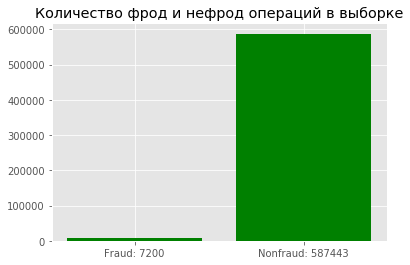

In [179]:
#Количество фрод операций значительно меньше, чем нефрод, то есть выборка ожидаемо несбалансированная

plt.style.use('ggplot')

x = [f'Fraud: {len(df_fraud)}', f'Nonfraud: {len(df_nonfraud)}']
y = [len(df_fraud), len(df_nonfraud)]
plt.bar(x, y, color='green')
plt.title("Количество фрод и нефрод операций в выборке")
plt.show()


#### Зависимость от категории трат.

In [58]:
# Мы видим, что в таких категориях как es_contents, es_food, es_transportation нет ни одной фрод трансакци.
# Наиболее скомпромитированные категории в абсолютном значении- это es_sportsandtoys и es_health
df_cat = df[['category', 'fraud']].groupby(['category']).sum().sort_values(by=['fraud'])
df_cat

,fraud
category,
es_contents,0.0
es_food,0.0
es_transportation,0.0
es_fashion,116.0
es_barsandrestaurants,120.0
es_tech,158.0
es_otherservices,228.0
es_hyper,280.0
es_home,302.0


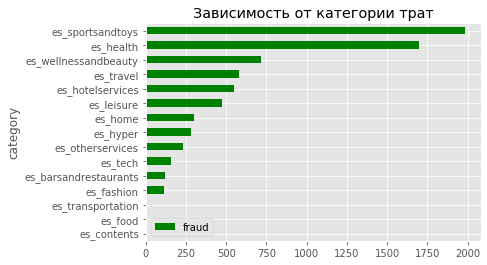

In [59]:
df_cat.plot.barh( 
            color = 'green', 
            title = 'Зависимость от категории трат',
            grid = True)

In [181]:
# Если  берем количество фрод трансакций в каждой категории трат по отношению 
# ко всему объему в категориях, то получаются такие результаты:
# В категориях es_fashion, es_barsandrestaurants, es_hyper, es_wellnessandbeauty и es_tech меньше 7 %
# В категориях  es_leisure почти все трансакции фродовые, в категории es_travel - большинство

,fraud
category,
es_sportsandtoys,1982
es_health,1696
es_wellnessandbeauty,718
es_travel,578
es_hotelservices,548
es_leisure,474
es_home,302
es_hyper,280
es_otherservices,228


In [269]:
df_cat_ = get_fraud_perc('category', df, df_fraud)
df_cat_

,fraud_,fraud_all,perc
category,,,
es_leisure,474,499,94.989980
es_travel,578,728,79.395604
es_sportsandtoys,1982,4002,49.525237
es_hotelservices,548,1744,31.422018
es_otherservices,228,912,25.000000
es_home,302,1986,15.206445
es_health,1696,16133,10.512614
es_tech,158,2370,6.666667
es_wellnessandbeauty,718,15086,4.759380


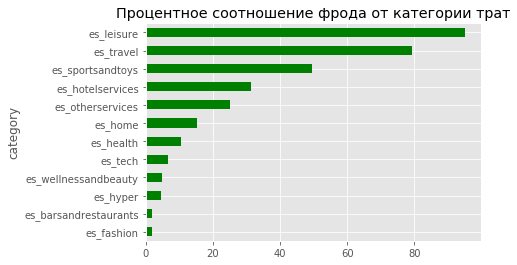

In [246]:
df_cat_['perc'].plot.barh( 
            color = 'green', 
            title = 'Процентное соотношение фрода от категории трат',
            grid = True)

#### Зависимость размера  трат

Максимальный объема нефрод единовременной трансакции составляет 2144.86.
То есть, если мы обнаруживаем у клиента больший объем единовременной трансакции,то это будет скорее всего фрод-трансакция.
Все нулевые трансакции - не фрод.

Разделим фрейм согласно объему трансакций на части от 0 до 2500 с шагом 500. Рассмотрим, какой объем фрод операций в каждой части. Обнаружим, что основной объем трансакций лежит в диапазоне до 1000 уе. Большинство  трансакций больше 750 уе - фрод трансакции. В диапазоне от 500 до 700 трансакций размер фрод трансакций в два раза больше нефрод 

In [83]:
df_fraud.sort_values(by=['amount'], ascending = False)

,step,customer,age,gender,merchant,category,amount,fraud
513394,158.0,C702798720,2,M,M732195782,es_travel,8329.96,1.0
135692,48.0,C806399525,2,F,M732195782,es_travel,7665.56,1.0
383889,122.0,C1007572087,2,F,M732195782,es_travel,7635.41,1.0
6710,2.0,C375144053,6,F,M732195782,es_travel,7432.48,1.0
329533,107.0,C430880678,2,M,M2080407379,es_travel,7403.44,1.0
...,...,...,...,...,...,...,...,...
300857,98.0,C1211514218,3,M,M923029380,es_home,0.19,1.0
474050,147.0,C23049140,5,F,M1198415165,es_wellnessandbeauty,0.11,1.0
250816,84.0,C2088631865,3,F,M1198415165,es_wellnessandbeauty,0.10,1.0
297694,97.0,C1647495093,3,M,M1748431652,es_wellnessandbeauty,0.04,1.0


In [84]:
df_nonfraud.sort_values(by=['amount'], ascending = False)

,step,customer,age,gender,merchant,category,amount,fraud
11735,4.0,C2110568911,2,F,M732195782,es_travel,2144.86,0.0
1697,0.0,C210584188,4,M,M732195782,es_travel,1993.68,0.0
170847,59.0,C1920498287,2,M,M732195782,es_travel,1954.73,0.0
185565,64.0,C232299558,3,F,M732195782,es_travel,1953.05,0.0
114080,41.0,C536412201,2,M,M495352832,es_travel,1805.59,0.0
...,...,...,...,...,...,...,...,...
236075,79.0,C1890250226,3,M,M348934600,es_transportation,0.00,0.0
449213,140.0,C1372042334,1,F,M348934600,es_transportation,0.00,0.0
365584,117.0,C1710930627,2,F,M1823072687,es_transportation,0.00,0.0
136697,48.0,C1812702959,3,F,M1823072687,es_transportation,0.00,0.0


In [292]:
amount = [250, 500,750, 1000,1500, 2000,2500]
df['new'] = pd.cut(df.amount, [0, 250, 500, 750, 1000,1500, 2000,2500], labels=amount,
                          right=False, include_lowest=True)

In [293]:
df[['fraud', 'new', 'amount']].groupby(['new', 'fraud']).count()

amount
new  fraud        
250  0.0    586350
     1.0      2783
500  0.0      1005
     1.0      2341
750  0.0        30
     1.0      1050
1000 0.0        27
     1.0       419
1500 0.0        20
     1.0       194
2000 0.0        10
     1.0        70
2500 0.0         1
     1.0        63

#### Зависимость от возраста

В абсолютном значении наиболее часто встечается фрод операции в возрастной категории 2: 26-35 лет.
Но если посчитать процентное соотношение всех трансакций в каждой категории к количеству фрода, то получается, что больший процента в возрасте  <= 18. 
В целом, этот параметр не очень информативный, тк даже в категории "до 18" процентное соотношение фрода - всего ок. 2%

In [247]:
df_age = get_fraud_perc('age', df, df_fraud)
df_age

,fraud_a,fraud_all,perc
age,,,
U,7,1178,0.594228
6,261,26774,0.974826
5,686,62642,1.095112
1,689,58131,1.185254
3,1755,147131,1.192815
2,2344,187310,1.251401
4,1410,109025,1.293281
0,48,2452,1.957586


#### Зависимость от пола
Количество фрод трансакций у категории  E: Компания (Enterprise) в абсолютном и процентном соотношении пренебрежимо невелика. 

В остальном этот параметр также как и возраст не очень информативный

In [249]:
df_gender = get_fraud_perc('gender', df, df_fraud)
df_gender

,fraud_a,fraud_all,perc
gender,,,
E,7,1178,0.594228
M,2435,268385,0.907279
F,4758,324565,1.465962


#### Зависимость от продавца

Если посмотреть на продавцов и отношение всех трансакций к количеству фрода, то есть те продавцы, трансакции к которым практически все являются фродом, а также есть те, у которых они минимальны.

In [252]:
df_merch = get_fraud_perc('merchant', df, df_fraud)
df_merch

,fraud_a,fraud_all,perc
merchant,,,
M1294758098,184,191,96.335079
M3697346,290,308,94.155844
M1873032707,216,250,86.400000
M732195782,518,608,85.197368
M980657600,1472,1769,83.210854
M1353266412,64,78,82.051282
M857378720,92,122,75.409836
M2080407379,36,48,75.000000
M2011752106,166,244,68.032787


#### Зависимость от клиента
Если посмотреть на клиентов и отношение всех трансакций к количеству фрода, то есть те клиенты, трансакции к которым практически все являются фродом, а также есть те, к которых они минимальны.

In [254]:
df_cust = get_fraud_perc('customer', df, df_fraud)
df_cust

,fraud_a,fraud_all,perc
customer,,,
C910454738,87,92,94.565217
C2004941826,119,126,94.444444
C381007057,89,100,89.000000
C1572610482,89,101,88.118812
C617723960,40,46,86.956522
...,...,...,...
C1307916597,1,183,0.546448
C1882101149,1,184,0.543478
C44857022,1,184,0.543478


#### Зависимость от дня
Предполагала, что возможно есть дни, в которых есть всплески фрод активностей. Но в этих синтетичесих данных каждый день случается 40 фрод трансакций

In [262]:
df_step = get_fraud_perc('step', df, df_fraud)
df_step.fraud_.unique()

array([40])

## Базовое решение

In [116]:
df_basic = df.copy()
df_basic['fraud'] = 0

In [109]:
#Тем трансакциям, в которых объем трансакций больше 2144.86, задаем значение 1(fraud)

In [118]:
df_basic.loc[df_basic['amount'] > 2144.86, 'fraud'] = 1

,step,customer,age,gender,merchant,category,amount,fraud
12,0.0,C623601481,3,M,M50039827,es_health,68.79,0
40,0.0,C1425441042,2,M,M1888755466,es_otherservices,87.67,0
42,0.0,C1635613216,4,F,M1053599405,es_health,105.59,0
79,0.0,C118437987,2,M,M1053599405,es_health,159.92,0
88,0.0,C583110837,3,M,M480139044,es_health,44.26,0
...,...,...,...,...,...,...,...,...
594624,179.0,C882083718,3,M,M349281107,es_fashion,71.83,0
594625,179.0,C882083718,3,M,M1600850729,es_fashion,26.48,0
594632,179.0,C1039390058,4,M,M1352454843,es_hotelservices,224.81,0
594633,179.0,C1039390058,4,M,M45060432,es_hotelservices,190.31,0


In [101]:
#Отсеиваем es_contents, es_food, es_transportation, в них нет фрода(Из 594643 строки осталось 62385)

In [117]:
df_basic = df_basic[~df_basic['category'].isin(['es_contents', 'es_food', 'es_transportation'] )]
# !!!!!!Может нужно не отсеивать, а в самом конце задать этим категориям значение 1 по умолчани.

## Preprocessing

В качестве target используется колонка fraud. Она бинарная, поэтому буду использовать ее без изменения

In [6]:
# В данной выборке все значения столбца zipcodeOri и zipMerchant = 28007.
# Поэтому можем избавиться от них
print(df.zipcodeOri.unique())
print(df.zipMerchant.unique()
     )

[28007.]
[28007.]


In [7]:
df.drop(['zipMerchant', 'zipcodeOri'], axis=1, inplace=True)

In [ ]:
# Преобразуем gender, age в числовое значение
df.loc[df['age'] == 'U', 'age'] = '7' 
df['age'] = df.age.astype(int)

# M: Мужской (Male) = 0
# F: Женский (Female) = 1
# E: Компания (Enterprise) = 2, 
# U: Неизвестно (Unknown) = 3
df.loc[df['gender'] == 'M', 'gender'] = 0
df.loc[df['gender'] == 'F', 'gender'] = 1
df.loc[df['gender'] == 'E', 'gender'] = 2
df.loc[df['gender'] == 'U', 'gender'] = 3

df['gender'] = df.gender.astype(int)

In [ ]:
df.info()

In [19]:
RANDOM_STATE = 777
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

In [20]:
y_train = df_train['fraud']
y_test = df_test['fraud']

In [9]:
task = Task(name='binary' ) # здесь задается тип решаемой задачи
roles = {'target': 'fraud'} # здесь задается название целевого признака 
automl = TabularAutoML(task=task, timeout=3600, memory_limit=10) # здесь создаем объект черной коробки LightAutoML
oof_pred = automl.fit_predict(df_train, roles=roles)

In [13]:
df

,step,customer,age,gender,merchant,category,amount,fraud
0,0.0,C1093826151,4,M,M348934600,es_transportation,4.55,0.0
1,0.0,C352968107,2,M,M348934600,es_transportation,39.68,0.0
2,0.0,C2054744914,4,F,M1823072687,es_transportation,26.89,0.0
3,0.0,C1760612790,3,M,M348934600,es_transportation,17.25,0.0
4,0.0,C757503768,5,M,M348934600,es_transportation,35.72,0.0
...,...,...,...,...,...,...,...,...
594638,179.0,C1753498738,3,F,M1823072687,es_transportation,20.53,0.0
594639,179.0,C650108285,4,F,M1823072687,es_transportation,50.73,0.0
594640,179.0,C123623130,2,F,M349281107,es_fashion,22.44,0.0
594641,179.0,C1499363341,5,M,M1823072687,es_transportation,14.46,0.0


In [21]:
df_test = df_test.drop('fraud',axis=1)
df_train = df_train.drop('fraud',axis=1)

Gini_train: 0.9984841221014302
Gini_test: 0.9975711910618583


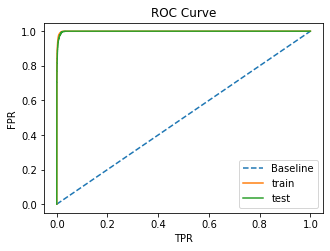

In [22]:
import matplotlib.pyplot as plt


y_train_score = automl.predict(df_train).data
y_test_score = automl.predict(df_test).data

print('Gini_train:', 2*roc_auc_score(y_train, y_train_score)-1)
print('Gini_test:', 2*roc_auc_score(y_test, y_test_score)-1)

curve1 = roc_curve(y_train, y_train_score)
curve2 = roc_curve(y_test, y_test_score)

plt.figure(figsize=(5, 3.5))
plt.plot([0, 1], label="Baseline", linestyle='--')
plt.plot(curve1[0], curve1[1], label='train')
plt.plot(curve2[0], curve2[1], label='test')
plt.title('ROC Curve')
plt.xlabel('TPR')
plt.ylabel('FPR')
plt.legend(loc = 4)
plt.show();


In [23]:
automl.get_feature_scores()

,Feature,Importance
0,amount,226278.858319
1,merchant,57230.306353
2,category,35959.463965
3,customer,15626.839403
4,step,12453.857836
5,age,2626.175654
6,gender,852.215438
